python: 3.8.5  
tensorflow: 2.4.1

In [1]:
import tensorflow as tf

In [2]:
import sys
print('python:', sys.version)
print('tensorflow:', tf.__version__)

python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
tensorflow: 2.4.1


## Импорт данных

Labels: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

getData: получает множество изображений и их метки по указанному пути 'path' к папке с категориями.

In [3]:
def getData(path):
    folders = tf.io.gfile.listdir(path)
    allFiles = []

    for i in range(len(folders)):
        files = tf.io.gfile.listdir(path + '\\' + folders[i])
        allFiles.extend(list(map(lambda f: [path + '\\' + folders[i] + '\\' + f, i], files)))

    images = []
    labels = []

    for file, i in allFiles:
        img_raw = tf.io.read_file(file)
        img = tf.io.decode_image(img_raw, channels=3)
        img = tf.image.resize(img, [28,28], method='bilinear')
        img = img / 255
        images.append(img)
        labels.append(i)
    
    return tf.stack(images), tf.one_hot(labels, 6)

In [4]:
train_data, train_labels = getData('data\seg_train\seg_train')

In [5]:
test_data, test_labels = getData('data\seg_test\seg_test')

In [6]:
pred_data = getData('data\seg_pred')[0]

Перемешиваем данные для последующего разделения на выборку для обучения и валидации.

In [7]:
indices = tf.range(start=0, limit=tf.shape(train_data)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

shuffled_train_data = tf.gather(train_data, shuffled_indices)
shuffled_train_labels = tf.gather(train_labels, shuffled_indices)

## Подготовка модели

Два сверточных слоя попарно с последующим пулингом + 'Dropout' для понижения переобучения модели.  
На вход, по условию, подаем изображения размерности 28x28x3.

In [38]:
from tensorflow import keras
from tensorflow.keras import layers


model = keras.Sequential()
model.add(keras.Input(shape=(28, 28, 3)))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                

## Обучение модели
Выделяем 20% выборки для валидации. После ~70 эпох модель начинает переобучатся без улучшения результата на валидационой выборке.

In [39]:
%%time
training_history = model.fit(shuffled_train_data, shuffled_train_labels, batch_size=150, epochs=70, validation_split=0.2)

Epoch 1/70
75/75 [==============================] - 4s 52ms/step - loss: 1.6128 - accuracy: 0.3186 - val_loss: 1.1943 - val_accuracy: 0.5550
Epoch 2/70
75/75 [==============================] - 4s 52ms/step - loss: 1.1610 - accuracy: 0.5444 - val_loss: 1.0594 - val_accuracy: 0.5978
Epoch 3/70
75/75 [==============================] - 4s 48ms/step - loss: 1.0315 - accuracy: 0.6071 - val_loss: 1.0288 - val_accuracy: 0.6095
Epoch 4/70
75/75 [==============================] - 4s 49ms/step - loss: 0.9819 - accuracy: 0.6273 - val_loss: 0.9639 - val_accuracy: 0.6462
Epoch 5/70
75/75 [==============================] - 4s 50ms/step - loss: 0.9243 - accuracy: 0.6549 - val_loss: 0.8988 - val_accuracy: 0.6797
Epoch 6/70
75/75 [==============================] - 4s 49ms/step - loss: 0.8842 - accuracy: 0.6818 - val_loss: 0.8822 - val_accuracy: 0.6851
Epoch 7/70
75/75 [==============================] - 4s 51ms/step - loss: 0.8610 - accuracy: 0.6822 - val_loss: 0.8641 - val_accuracy: 0.6911
Epoch 8/70
75

75/75 [==============================] - 4s 48ms/step - loss: 0.5317 - accuracy: 0.8081 - val_loss: 0.6469 - val_accuracy: 0.7759
Epoch 59/70
75/75 [==============================] - 4s 47ms/step - loss: 0.5208 - accuracy: 0.8158 - val_loss: 0.6374 - val_accuracy: 0.7763
Epoch 60/70
75/75 [==============================] - 4s 48ms/step - loss: 0.5315 - accuracy: 0.8104 - val_loss: 0.6366 - val_accuracy: 0.7788
Epoch 61/70
75/75 [==============================] - 4s 48ms/step - loss: 0.5308 - accuracy: 0.8063 - val_loss: 0.6310 - val_accuracy: 0.7802
Epoch 62/70
75/75 [==============================] - 4s 47ms/step - loss: 0.5227 - accuracy: 0.8136 - val_loss: 0.6486 - val_accuracy: 0.7773
Epoch 63/70
75/75 [==============================] - 4s 48ms/step - loss: 0.5430 - accuracy: 0.7997 - val_loss: 0.6354 - val_accuracy: 0.7845
Epoch 64/70
75/75 [==============================] - 4s 48ms/step - loss: 0.5397 - accuracy: 0.8103 - val_loss: 0.6546 - val_accuracy: 0.7724
Epoch 65/70
75/75 

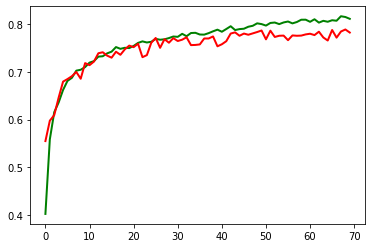

In [40]:
import matplotlib.pyplot as plt

plt.plot(training_history.history['accuracy'], color = 'g', lw = 2)
plt.plot(training_history.history['val_accuracy'], color = 'r', lw = 2)

In [41]:
model.save('test_model')

INFO:tensorflow:Assets written to: test_model\assets


## Оценка модели
Загружаем ранее сохраненную модель, оцениваем на тестовой выборке.

In [42]:
model = tf.keras.models.load_model('test_model')

In [43]:
loss, acc = model.evaluate(test_data, test_labels)

print('\nloss', loss)
print('accuracy', acc)

94/94 [==============================] - 0s 3ms/step - loss: 0.5969 - accuracy: 0.7897

loss 0.5969492793083191
accuracy 0.7896666526794434


## Предсказание
Высчитываем результат модели на наборе 'seg_pred'

In [44]:
predictions = model.predict(pred_data)
print(predictions)

[[1.0498457e-01 3.0131401e-02 8.5823890e-04 7.3806167e-04 2.6760423e-03
  8.6061174e-01]
 [3.4015160e-02 5.5745436e-04 7.9260945e-02 6.5453565e-01 2.2887132e-01
  2.7594257e-03]
 [2.0512423e-01 2.0587462e-01 1.2512397e-06 7.8109355e-07 1.3312178e-04
  5.8886600e-01]
 ...
 [3.7261795e-03 1.0473605e-04 1.2677769e-01 3.3676404e-01 5.2951360e-01
  3.1138191e-03]
 [3.2252506e-06 9.9998558e-01 4.8695438e-07 3.9794236e-07 1.3844753e-07
  1.0307326e-05]
 [5.9334505e-02 5.7411287e-04 1.1016325e-04 2.4343211e-07 1.1075348e-04
  9.3987024e-01]]


### Дополнение
Смотрим результат предсказания для случайного изображения из набора 'seg_pred'

In [45]:
import numpy as np

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
[[0.10832875 0.5497684  0.0032214  0.00309035 0.0074774  0.3281138 ]]

predicted: forest 
value: 0.5497684


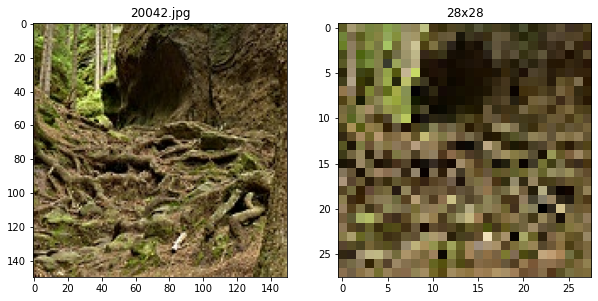

In [46]:
from random import randint
index = randint(0, 7300)

files = tf.io.gfile.listdir('data\seg_pred\seg_pred')

img_path = 'data\\seg_pred\\seg_pred\\' + files[index]

img_raw = tf.io.read_file(img_path)
img = tf.io.decode_image(img_raw)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, [150,150])

plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.title(files[index])
plt.imshow(img)

img_raw = tf.io.read_file(img_path)
img = tf.io.decode_image(img_raw, channels=3)
img = tf.image.resize(img, [28,28], method='bilinear')
img = img / 255

plt.subplot(122)
plt.title('28x28')
plt.imshow(img)

labels = tf.io.gfile.listdir('data\seg_train\seg_train')
prediction = model.predict(tf.stack([img]))

print(labels)
print(prediction)

print('\npredicted:', labels[prediction.argmax()], '\nvalue:', prediction.max())